In [1]:
# Chosen using results from Bipolar-K
epsilon = 0.75
k = 250

input_dim = 13166
num_clusters = 18

model_file = "../Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt"
pc_matrix_file = "../Bipolar/Data/bipolar_pc.tsv"

import csv
import json
import matplotlib
import numpy as np
import os
import pandas as pd

os.system("rm *.png")

import sys
sys.path.insert(0, "../Bipolar/")
from load_aug import load_aug

sys.path.insert(0, "../Code/")
from metrics import metrics
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation
from misc import poly2labels

matplotlib.rc("lines", markersize = 4)# Override some default plot parameters

def load_model(input_dim = input_dim, model_file = model_file):
    return load_aug(input_dim, model_file, feature_transform = pc_matrix_file)


In [2]:
# Load Data & Configuration

x = pd.read_csv("../Bipolar/Data/bipolar_rep_scaled.tsv", sep="\t").values

with open("../Bipolar/vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Approximate the original data

matrix = pd.read_csv(pc_matrix_file, sep = "\t", header = None).values

x_full = np.matmul(x, np.transpose(matrix))

In [4]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

INFO:tensorflow:Restoring parameters from ../Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


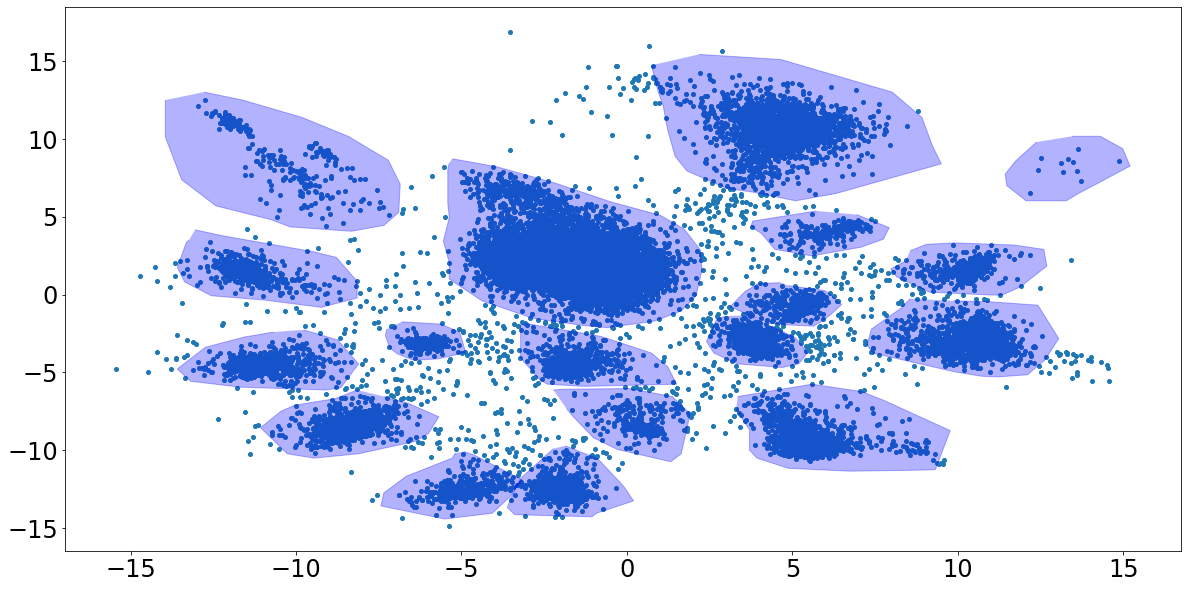

In [5]:
# Visualize the data and the marked clusters
plot_polys(data_rep, all_vertices)

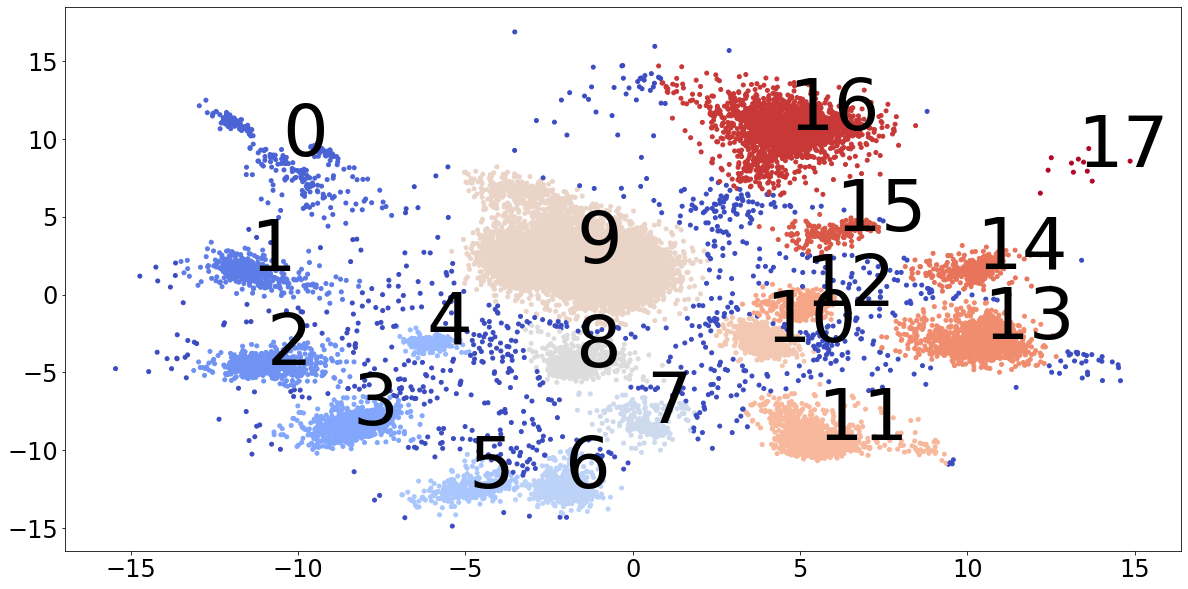

In [6]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x_full, data_rep, num_clusters, labels, name = "bipolar-rep.png")


In [7]:
import tensorflow as tf

sys.path.insert(0, "../Code/")
from base import MLP, BatchManager  

# Format the data to train a classifier

not_labeled = np.where(labels > -1)[0] #Drop the unassigned points

x_class = data_rep[not_labeled, :]
y_class = labels[not_labeled]

from sklearn.model_selection import train_test_split
x_class, x_class_test, y_class, y_class_test = train_test_split(x_class, y_class)

bm = BatchManager(x_class, y_class)

# Build the classifier
R = tf.compat.v1.placeholder("float", [None, 2], name = "R_in")
Y = tf.compat.v1.placeholder(tf.int64, shape = [None])
I = tf.compat.v1.placeholder(tf.int64, shape = None)

with tf.compat.v1.variable_scope("stack", reuse = tf.compat.v1.AUTO_REUSE):

    learner = MLP([2, 100, 100, 18])
    with tf.compat.v1.variable_scope("learner_model", reuse = tf.compat.v1.AUTO_REUSE):
        prob = tf.nn.softmax(learner.model(rep), axis = 1)
    
    p_i = tf.gather(prob, indices = [I], axis = 1)
    g_i = tf.gradients(ys=p_i, xs=X)
            
    with tf.compat.v1.variable_scope("learner_model", reuse = tf.compat.v1.AUTO_REUSE):
        pred_from_rep = learner.model(R)

    loss_op = tf.reduce_mean(input_tensor=tf.nn.sparse_softmax_cross_entropy_with_logits(labels = Y, logits = pred_from_rep))
    tf.compat.v1.summary.scalar("Cross_Entropy", loss_op)

     
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = 0.01)
    train_op = optimizer.minimize(loss_op)

    summary_op = tf.compat.v1.summary.merge_all()

# Init all new variables
# scope_variables=  tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.VARIABLES, scope = "stack" )
scope_variables=  tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.GLOBAL_VARIABLES, scope = "stack" )
init_scope = tf.compat.v1.variables_initializer(scope_variables, name = "init_stack")
sess.run(init_scope)

# Train
for i in range(1000):
    x_batch, y_batch = bm.next_batch(batch_size = 32)
    sess.run([train_op], feed_dict = {R: x_batch, Y: y_batch})

print("")
out = sess.run(pred_from_rep, feed_dict = {R: x_class})
print("Train Accuracy:", np.mean(np.argmax(out, axis = 1) == y_class))
out = sess.run(pred_from_rep, feed_dict = {R: x_class_test})
print("Test Accuracy:", np.mean(np.argmax(out, axis = 1) == y_class_test))


Train Accuracy: 0.9993990986479719
Test Accuracy: 0.9993991287366681


In [8]:
def info(x, i):
    p, g = sess.run([prob, g_i], feed_dict = {X: x, I: i, D: np.zeros((1, input_dim))})
    return p, g[0]

sys.path.insert(0, "../Integrated-Gradients-master/IntegratedGradients/")
from integrated_gradients import integrated_gradients

deltas = []
for g in range(1, num_clusters):
    count = 0
    average = np.zeros((input_dim))
    for index_ref in indices[0][:100]:
        baseline = x_full[index_ref, :]
        for index_target in indices[g][:100]:
            x = x_full[index_target, :]
            ig, _ = integrated_gradients(x, g, info, baseline)
            
            average += ig
            count += 1
    deltas.append(average/count)
    print("Finished ", g)
    
deltas = np.array(deltas)
np.save("deltas_ig_short.npy", deltas)



Finished  1
Finished  2
Finished  3
Finished  4
Finished  5
Finished  6
Finished  7
Finished  8
Finished  9
Finished  10
Finished  11
Finished  12
Finished  13
Finished  14
Finished  15
Finished  16
Finished  17


INFO:tensorflow:Restoring parameters from ../Bipolar/Model/model/perplexity_10_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_5400.ckpt


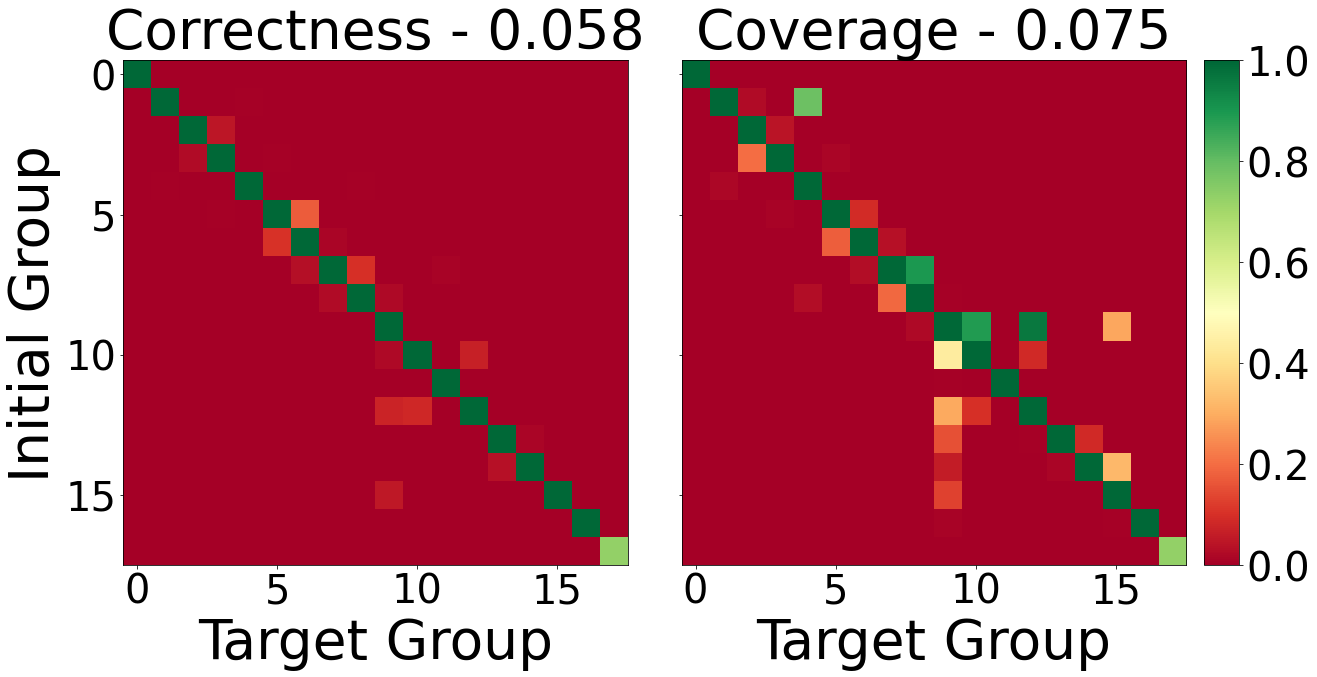

In [9]:
a, b = metrics(load_model, x_full, indices, deltas, epsilon)
plot_metrics(a, b, name = "bipolar-metrics-ig.png")

In [10]:
from scipy.stats import spearmanr

from misc import truncate

deltas = np.load("deltas_ig_short.npy")

deltas_dbm = np.zeros((num_clusters - 1, input_dim))
for i in range(num_clusters - 1):
    deltas_dbm[i, :] = means[i + 1] - means[0]
    
def check(deltas, deltas_tgt, deltas_dbm):
    ig_dbm = 0.0
    ig_tgt = 0.0
    tgt_dbm = 0.0
    for i in range(num_clusters-1):
        v = np.corrcoef(deltas[i], deltas_dbm[i])[0, 1]
        ig_dbm += v
        v = np.corrcoef(deltas[i], deltas_tgt[i])[0, 1]
        ig_tgt += v
        v = np.corrcoef(deltas_tgt[i], deltas_dbm[i])[0, 1]
        tgt_dbm += v
    
    ig_dbm /= num_clusters - 1
    ig_tgt /= num_clusters - 1
    tgt_dbm /= num_clusters - 1

    print("IG vs DBM", ig_dbm)
    print("IG vs TGT", ig_tgt)
    print("TGT vs DBM", tgt_dbm)
    
def check_rank(deltas, deltas_tgt, deltas_dbm):
    ig_dbm = 0.0
    ig_tgt = 0.0
    tgt_dbm = 0.0
    for i in range(num_clusters-1):
        v, _ = spearmanr(deltas[i], deltas_dbm[i])
        ig_dbm += v
        v, _  = spearmanr(deltas[i], deltas_tgt[i])
        ig_tgt += v
        v, _ = spearmanr(deltas_tgt[i], deltas_dbm[i])
        tgt_dbm += v
    
    ig_dbm /= num_clusters - 1
    ig_tgt /= num_clusters - 1
    tgt_dbm /= num_clusters - 1

    print("IG vs DBM", ig_dbm)
    print("IG vs TGT", ig_tgt)
    print("TGT vs DBM", tgt_dbm)
    
def intersect(a, b, k):
    
    v = 0.0
    for i in range(num_clusters - 1):
        a_used = 1.0 * (a[i] != 0)
        b_used = 1.0 * (b[i] != 0)
        both = a_used * b_used
        v += np.sum(both)
    return v / ((num_clusters - 1) * min(k, a.shape[1]))
          
for k in [15000, 1000, 500, 250, 100, 50]:
    print("\n", k)
    
    deltas_tgt = np.load("../Bipolar-K/deltas" + str(k) + ".npy")
    
    for i in range(num_clusters-1):
        deltas[i] = truncate(deltas[i], k)
        deltas_dbm[i] = truncate(deltas_dbm[i], k)
        deltas_tgt[i] = truncate(deltas_tgt[i], k)

    print("Correlation")
    check(deltas, deltas_tgt, deltas_dbm)
    print("Correlation - abs")
    check(np.abs(deltas), np.abs(deltas_tgt), np.abs(deltas_dbm))

    print("Rank Correlation")
    check_rank(deltas, deltas_tgt, deltas_dbm)
    print("Rank Correlation - abs")
    check_rank(np.abs(deltas), np.abs(deltas_tgt), np.abs(deltas_dbm))
    
    print("Intersect")
    print("IG vs DBM ", intersect(deltas, deltas_dbm, k))
    print("IG vs TGT ", intersect(deltas, deltas_tgt, k))
    print("TGT vs DBM ", intersect(deltas_tgt, deltas_dbm, k))




 15000
Correlation
IG vs DBM -0.6009165846924917
IG vs TGT -0.3160203313567719
TGT vs DBM 0.7219651700278941
Correlation - abs
IG vs DBM 0.8682075904488822
IG vs TGT 0.5963192371083746
TGT vs DBM 0.7135597319763937
Rank Correlation
IG vs DBM 0.06703634001346752
IG vs TGT 0.05636822778312446
TGT vs DBM 0.42190302874296853
Rank Correlation - abs
IG vs DBM 0.6187966145428876
IG vs TGT 0.4566074238865628
TGT vs DBM 0.2713036336426188
Intersect
IG vs DBM  1.0
IG vs TGT  1.0
TGT vs DBM  1.0

 1000
Correlation
IG vs DBM -0.6220841602658401
IG vs TGT -0.3551896975335879
TGT vs DBM 0.7647525742576599
Correlation - abs
IG vs DBM 0.8660453824992965
IG vs TGT 0.6458347778971923
TGT vs DBM 0.7614120027491947
Rank Correlation
IG vs DBM 0.02849466555908901
IG vs TGT -0.087836347600215
TGT vs DBM 0.4870049990927626
Rank Correlation - abs
IG vs DBM 0.6729482800564537
IG vs TGT 0.4985956144442086
TGT vs DBM 0.47612006201574497
Intersect
IG vs DBM  0.6798235294117647
IG vs TGT  0.5161764705882353
TGT vs